# Long Short Term Memory

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more.

LSTM Model:  
Goal: The dataset and pre-trained models in this page can be used to reproduce Recursive Neural Networks in Phil’s talk:  
July 15 2019 [talk](https://drive.google.com/open?id=1b62jf6w-UeJsq2vFQdw1Hm77h_voIb-d)  
Aug 15 2019 [talk](https://drive.google.com/open?id=1B8x-6u9xex03hiVMQkCHgDXvCTdbiJQG)

Input features (6): 
 - j1_ptrel 
 - j1_etarot 
 - j1_phirot 
 - j1_erel 
 - j1_deltaR
 - j1_pdgid
MaxParticles: 20

Labels (5): 
- j_g 
- j_q 
- j_w 
- j_z 
- j_t


In [1]:
import keras
from keras.layers import Input, Dense, Flatten, LSTM
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# To use one data file:
h5File = h5py.File('processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = h5File['t_allpar_new'][()]

h5File.close()

print(treeArray.shape)

# List of features to use
features = ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_pdgid', 'j_index']

# List of labels to use
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

# Convert to dataframe
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]
labels_df = labels_df.drop_duplicates()

# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values     

if 'j_index' in features:
    features_val = features_val[:,:-1] # drop the j_index feature
if 'j_index' in labels:
    labels_val = labels_val[:,:-1] # drop the j_index label
    print(labels_val.shape)

(5131613,)
(98769, 5)


In [3]:
MaxParticles = 20
features_2dval = np.zeros((len(labels_df), MaxParticles, len(features)-1))
for i in tqdm(range(0, len(labels_df))):
    features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values
    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]] # sort descending by ptrel
    if nParticles > MaxParticles:
        features_val_i =  features_val_i[0:MaxParticles, :]
    else:        
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles-nParticles, len(features)-1))])
    features_2dval[i, :, :] = features_val_i
features_val = features_2dval

100%|██████████| 98769/98769 [12:30<00:00, 131.55it/s]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [5]:
#Normalize conv inputs
reshape_X_train_val = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train.shape[1]):
    X_train[:,p,:] = scaler.transform(X_train[:, p, :])
    X_test[:,p,:] = scaler.transform(X_test[:, p, :])    

if 'j_index' in labels:
    labels = labels[:-1]

# Self_Build Model

In [6]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))
x = LSTM(16,return_sequences=True,  kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu',kernel_initializer='lecun_uniform',name='lstm_lstm',
         dropout=0.001, recurrent_dropout=0.00001)(Inputs)
x = Flatten()(x)
#x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Run training

In [7]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 38s 20ms/step - loss: 1.1131 - accuracy: 0.6110 - val_loss: 1.0056 - val_accuracy: 0.6671
Epoch 2/100
1852/1852 [==============================] - 34s 19ms/step - loss: 0.9684 - accuracy: 0.6746 - val_loss: 0.9763 - val_accuracy: 0.6594
Epoch 3/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.9283 - accuracy: 0.6874 - val_loss: 0.9226 - val_accuracy: 0.6901
Epoch 4/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.9098 - accuracy: 0.6904 - val_loss: 0.9033 - val_accuracy: 0.6936
Epoch 5/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8976 - accuracy: 0.6943 - val_loss: 0.8903 - val_accuracy: 0.6965
Epoch 6/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8892 - accuracy: 0.6971 - val_loss: 0.8817 - val_accuracy: 0.7001
Epoch 7/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8843 - accuracy: 0.6972 - val_loss: 0

1852/1852 [==============================] - 33s 18ms/step - loss: 0.8291 - accuracy: 0.7158 - val_loss: 0.8575 - val_accuracy: 0.7059
Epoch 57/100
1852/1852 [==============================] - 31s 17ms/step - loss: 0.8317 - accuracy: 0.7154 - val_loss: 0.8406 - val_accuracy: 0.7139
Epoch 58/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8307 - accuracy: 0.7168 - val_loss: 0.8405 - val_accuracy: 0.7148
Epoch 59/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8292 - accuracy: 0.7173 - val_loss: 0.8356 - val_accuracy: 0.7173
Epoch 60/100
1852/1852 [==============================] - 31s 17ms/step - loss: 0.8286 - accuracy: 0.7161 - val_loss: 0.8726 - val_accuracy: 0.7013
Epoch 61/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8285 - accuracy: 0.7160 - val_loss: 0.8487 - val_accuracy: 0.7102
Epoch 62/100
1852/1852 [==============================] - 32s 17ms/step - loss: 0.8276 - accuracy: 0.7160 - val_loss: 0.8503 

# Test

### Exercise

Make a function to plot the learning curve and ROCs. Results have been provided for comparsion

In [13]:
# make function here

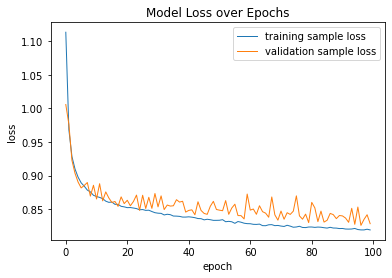

In [10]:
learningCurveLoss(history)

In [11]:
# make function here

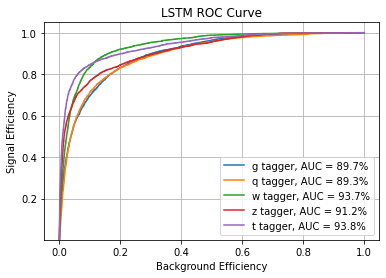

In [12]:
# call function here